# Instance-based Counterfactual Explanations for Time Series Classification

A counterfactual explanation, originally introduced to machine learning by [2], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Delaney et al.[1] proposed using the K-nearest neighbors from the dataset belonging to a different class as native guide to generate counterfactuals. They propose three options for transforming the original time series with this native guide: the plain native guide, the native guide with bary centering, and transformation based on the native guide and class activation mapping. The desired method can be selected by providing the method parameter during interpretability instantiation.

<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/Nun_Grad.png" alt="Visualization of Nun-CF" style="width: 800px;"/>

The code in TSInterpret is based on the authors <a href='https://github.com/e-delaney/Instance-Based_CFE_TSC'>implementation </a>.

[1] E. Delaney, D. Greene, and M. T. Keane. Instance-Based Counterfactual Explanations for Time Series Classification. In A. A. S ́anchez-Ruiz and M. W.Floyd, editors, Case-Based Reasoning Research and Development, volume 12877, pages 32–47. Springer International Publishing, Cham, 2021. ISBN 978-3-030-86956-4 978-3-030-86957-1. doi: 10.1007/978-3-030-86957-1 3. Series Title: Lecture Notes in Computer Science.

[2] Wachter, Sandra, Brent Mittelstadt, and Chris Russell. "Counterfactual explanations without opening the black box: Automated decisions and the GDPR." Harv. JL & Tech. 31 (2017): 841.

In [64]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from TSInterpret_Artifacts.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, fit
import warnings
warnings.filterwarnings("ignore") 

from tslearn.preprocessing import TimeSeriesScalerMinMax
import matplotlib.pyplot as plt


## Load Data

Load Data and reshape the data to fit a 1D-Conv ResNet. Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [3]:
dataset='Coffee'

In [60]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
#train_x = train_x.reshape(-1,1,  train_x.shape[-2])
#test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

In [53]:
train_x.shape

(28, 1, 286)

## Model Training / Loading
Trains a ResNet and saves the results.

In [66]:
# Shapelets

from tslearn.shapelets import LearningShapelets

model = LearningShapelets(n_shapelets_per_size={30: 2})
model.fit(train_x, train_y)
train_distances = model.transform(train_x)
test_distances = model.transform(test_x)
shapelets = model.shapelets_as_time_series_


In [71]:
predicted_locations

array([[  5,  62],
       [  7,  62],
       [  9,  62],
       [  8,  62],
       [  3, 117],
       [  6,  63],
       [  7,  61],
       [  8,  63],
       [  5,  61],
       [  2,  61],
       [  3,  61],
       [  1, 102],
       [  2, 102],
       [  3, 116],
       [  7,  61],
       [  8,  92],
       [  6,  61],
       [  5,  61],
       [  8,  61],
       [  9,  61],
       [  6,  63],
       [  3,  61],
       [  5,  61],
       [  4,  60],
       [  3,  61],
       [  8,  61],
       [  3,  61],
       [  2,  61]])

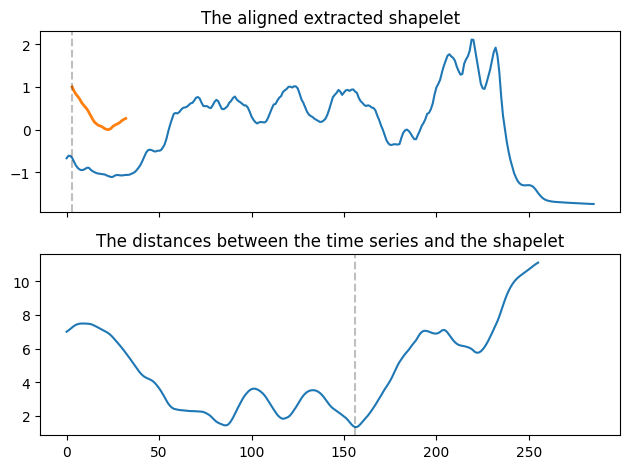

In [68]:
distances = model.transform(train_x)
predicted_locations = model.locate(train_x)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.
test_ts_id = np.argmin(np.sum(distances, axis=1))
shap = model.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(train_x[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances = []
time_series = train_x[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances)
ax[1].axvline(np.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

In [7]:
# CNN (ResNet)

n_pred_classes = 2
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
fit(model, train_loader, test_loader, num_epochs=50) 

# model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
# state_dict= torch.load(f'../../ClassificationModels/models/{dataset}/ResNet')
# model.load_state_dict(state_dict)

Epoch: 1, Train loss: 0.718, Val loss: 0.686
Epoch: 2, Train loss: 1.12, Val loss: 0.714
Epoch: 3, Train loss: 0.814, Val loss: 0.691
Epoch: 4, Train loss: 0.711, Val loss: 0.691
Epoch: 5, Train loss: 0.698, Val loss: 0.697
Epoch: 6, Train loss: 0.698, Val loss: 0.692
Epoch: 7, Train loss: 0.7, Val loss: 0.695
Epoch: 8, Train loss: 0.697, Val loss: 0.693
Epoch: 9, Train loss: 0.701, Val loss: 0.691
Epoch: 10, Train loss: 0.7, Val loss: 0.693
Epoch: 11, Train loss: 0.711, Val loss: 0.691
Epoch: 12, Train loss: 0.703, Val loss: 0.697
Epoch: 13, Train loss: 0.699, Val loss: 0.695
Epoch: 14, Train loss: 0.697, Val loss: 0.692
Epoch: 15, Train loss: 0.702, Val loss: 0.692
Epoch: 16, Train loss: 0.698, Val loss: 0.693
Epoch: 17, Train loss: 0.699, Val loss: 0.693
Epoch: 18, Train loss: 0.698, Val loss: 0.692
Epoch: 19, Train loss: 0.699, Val loss: 0.693
Epoch: 20, Train loss: 0.703, Val loss: 0.694
Epoch: 21, Train loss: 0.698, Val loss: 0.693
Epoch: 22, Train loss: 0.705, Val loss: 0.695
Ep

In [49]:
train_loader.dataset.feature.shape

(28, 1, 286)

## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading  & Instantiation
Native Guide counterfactuals works on all models tensorflow and pyTorch models returning a probability function. The Initialization takes the following arguments:


    `model`: The model to be explaines.
    `shape`: The data shape in form of (features, timesteps).
    `data`: Tuple of Data and Labels used to find and build CF.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: ['NUN_CF', "dtw_bary_center", 'NG'].


In [55]:
model.eval()
item=test_x[20] #.reshape(1,1,-1)
_item=test_x[20].reshape(1,1,-1)

shape=item.shape
_item=  torch.from_numpy(_item).float()
model.eval()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [56]:
from TSInterpret_Artifacts.InterpretabilityModels.NativeGuideCF import NativeGuideCF
exp_model=NativeGuideCF(model,(train_x,train_y), backend='PYT', mode='time',method='NUN_CF')

### 3. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained.
- `target`: desired target class of CF.

In [57]:
item.shape

(1, 286)

In [ ]:
exp,label = exp_model.explain(item, np.argmax(y_target,axis=1)[0])

IndexError: tuple index out of range

### 4. Visualization

Plot function takes as input the item to be explained and the returned explanation, as well as the assigned labels.

In [ ]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

TypeError: CF.plot() missing 2 required positional arguments: 'exp' and 'exp_label'

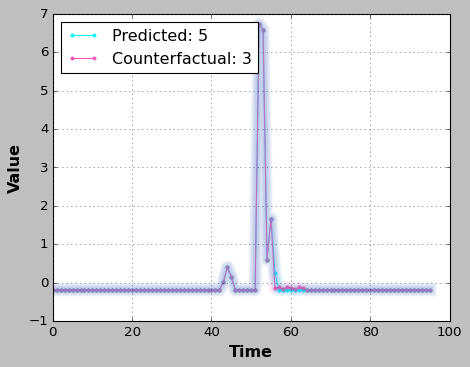

In [10]:
exp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)

Additional Examples, e.g. for the use with LSTM or TF can be found <a href='https://github.com/JHoelli/TSInterpret/blob/main/docs/Notebooks'>here</a>.

In [2]:
import TSInterpret